# Convergence
### In this notebook, we document the experiments on the reconstruction error for a fixed image resolution but three different noise models and decaying noise level. 

### We first import the packages and the data we need. For more information on the pre-saved operators and coefficients, please refer to the README.

In [1]:
## necessary to compute reconstructions
# packages
import numpy as np
from skimage.transform import resize

# custom classes and functions
from ops import reco_op, svd_op
from filters import filter
## necessary to load pre-saved operators
import pickle

## necessary for image loading and visualization
import matplotlib.pyplot as plt
import sys

### The example that is included in the paper was performed for images of the shape $128 \times 128$. 
#### 💡For faster computations, or to get an idea of the behavior in the continuum limit, you can also change the resolution $\texttt{res}$ here.

In [2]:
# specify custom data location
data_folder = "spectralData"

# choose resolution
res = 128 # pre-saved alternatives: res = 32, res = 64

# load pre-saved radon operator for resolution 128x128
with open(data_folder + "/radon_" + str(res) + ".obj", "rb") as f:
    r = pickle.load(f)

# load pre-saved data coefficients for the above operators and a subset of 2400 test instances of the LoDoPaB CT Dataset.
Pi = np.loadtxt(data_folder + "/pi"+ str(res) + ".txt")

# load example image and resize it to different resolutions
img = resize(plt.imread(data_folder + "/test_img.png")[..., 0], (res,res))
                
# compute and store the corresponding sinogram
sino =  r(img)

### Before we start to compute the reconstruction errors, we first inspect what noise with different decays of the noise coefficients $\Delta = \{\Delta_n\}_{n \in \mathbb{N}}$ typically looks like.
#### Therefore, we define three different decays $\sqrt{\Delta}$ and prepare the transformation matrix $V$. (This is necessary, because the pre-saved version of V does not fit the sinograms, to save memory).

In [3]:
# the pre-saved operators contain the singular value decompositon A = V@diag(sigma)@U (see README)
U_dim = r.U.shape[-2] # number of singular values and filter length
V_dim = r.V.shape[-2] # number of entries per sinogram, i.e., size of noise 

full = np.max((U_dim, V_dim)) # we want to compute the decay sequence for both sizes, U_dim for the optimal filter and V_dim to sample from the noise (for visualization)

# sequence 1,2,3,...,full-2,full-1 
n = np.arange(full) + 1

# we choose three different decays: A training decay, more decay that during training, and less decay than during training
decay = {'training': 1/np.sqrt(np.sqrt(n)), 'less': np.ones(full), 'more': 1/(n**2)}

# The matrix of the left singular values V is extended to fit the sinogram size and will be used as the transformation matrix
V_full = np.zeros((V_dim, V_dim))
V_full[:,:r.V.shape[-1]] = r.V

### We now generate a few samples of noise as
### $$\epsilon = V^T \left(\sqrt{\Delta} \cdot \hat{\epsilon}\right),$$
### with $\hat{\epsilon} \sim \mathcal{N}(0,I)$.
#### This yields the desired noise coefficients $\Delta = \{\Delta_n\}_{n \in \mathbb{N}}$, since with the orthonormality of V we have 
$$ \mathbb{E}_{\epsilon}\left[\langle \epsilon, v_n\rangle^2\right] = \mathbb{E}_{\hat{\epsilon} \sim \mathcal{N}(0,I)} \left[\langle V^T \left(\sqrt{\Delta} \cdot \hat{\epsilon}\right), v_n\rangle^2\right] = \mathbb{E}_{\hat{\epsilon} \sim \mathcal{N}(0,I)} \left[\langle  \sqrt{\Delta} \cdot \hat{\epsilon}, V^T v_n\rangle^2\right]= \mathbb{E}_{\hat{\epsilon} \sim \mathcal{N}(0,I)} \left[\langle  \sqrt{\Delta} \cdot \hat{\epsilon}, e_n\rangle^2\right] = \Delta_n,$$
#### where $e_n$ denotes the standard basis vector.

In [4]:
# Choose number of noise samples to approximate expected error
K = 10

# prepare noise for each sample
proto_noise = np.random.normal(scale=1, size = (V_dim,K))
# adapt proto noise for the test noise model 
noise = {'stronger': V_full@((proto_noise.T*decay['less'][:V_dim]).T), # less noise decay = stronger noise
          'training': V_full@((proto_noise.T*decay['training'][:V_dim]).T), 
           'weaker': 100*V_full@((proto_noise.T*decay['more'][:V_dim]).T) # we use a proportionality constant of 100 here, such that the results are easier to compare. This does not change the convergence behavior.
        }

### 🔎 Let's see what noise instances with different decays of noise coefficients typically look like
#### 🔁 To see a different sample, run this cell again.

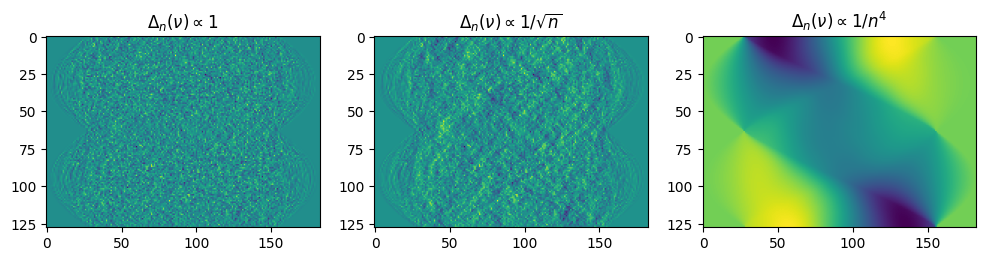

In [5]:
# sample a sample :)
sample = np.random.randint(K)

fig, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].imshow(noise['stronger'][:,sample].reshape(res,-1))
axs[0].set_title(r'$\Delta_n(\nu) \propto 1$')
axs[1].imshow(noise['training'][:,sample].reshape(res,-1))
axs[1].set_title(r'$\Delta_n(\nu) \propto 1/\sqrt{n}$')
axs[2].imshow(noise['weaker'][:,sample].reshape(res,-1))
axs[2].set_title(r'$\Delta_n(\nu) \propto 1/n^4$')

plt.show()

### We now want to investigate how the different approaches perform. We assume all approaches to be **trained** on noise $\mu(\delta)$ with
$$\Delta_n(\mu(\delta)) = \frac{\delta^2}{\sqrt{n}}.$$
### But: The **test** measurements will be corrupted by noise drawn from three different distributions $\nu(\delta)$ with 
$$\Delta_n(\nu(\delta)) \propto \frac{\delta^2}{n^4}, \;\Delta_n(\nu(\delta)) \propto \frac{\delta^2}{\sqrt{n}}, \text{ and }\Delta_n(\nu(\delta)) \propto \delta^2.$$

#### 🔎 To compute some reconstructions for the different approaches, noise decays and noise levels, you can run the following cell, or, check out our paper.
#### ⏳ Depending on your machine, this might take quite some time. The computations performed in the next cell are NOT necessary to run the rest of this notebook.

In [6]:
# ⚠️ THIS CELL TAKES QUITE SOME TIME AND CAN BE SKIPPED ⚠️
skip = True
if not skip:    
    # the noise levels we test
    deltas = [0.1,0.01,0.001]

    # store all results for visualization in this dict:
    errors = {k: {'stronger': [], 'problem': [], 'weaker':[]} for k in ['mse', 'post', 'adv']}

    verbose = 1

    # iterate over methods
    for method in errors.keys():

        # iterate over noise levels
        for delta in deltas:

            # compute optimal filter for training decay
            g = filter(Pi, (delta*decay['training'][:U_dim])**2, r.sigma, method = method)
            rec_op = reco_op(r.U, r.V, g, res)

            #reconstruct each sample and compute error for each test noise model \nu
            for nu in noise.keys():

                # set running error to zero
                running = 0
                # the noise we add is scaled by the noise level
                reco = rec_op.reconstruct(sino+delta*noise[nu][:,0].reshape([res,-1]))

                fname = 'visualization/'+ method + '_' + nu + str(delta) + '.pdf' 
                plt.imsave(fname, reco.reshape([res,-1]), cmap='gray')

            if verbose > 0:
                print('Finished noise level ' + str(delta))

        if verbose > 0:        
            print('Finished method ' + method)

### The reconstruction error for a ground truth image $x$ is given by
### $$ \mathbb{E}_{\epsilon \sim \nu^{\delta}} \left[\|R_{\mu}(Ax+\epsilon) - x\|^2\right] = \color{gray}{\|x_0\|^2} + \color{red}{\|R_{\mu}(Ax) - x\|^2} + \color{teal}{\mathbb{E}_{\epsilon \sim \nu^{\delta}} \left[\|R_{\mu}(\epsilon)\|^2\right]}.$$
* The squared norm of the $\color{gray}{\text{null-space element}}$ can be computed as $ \|A^{\dagger}Ax - x\|^2$.
* The $\color{red}{\text{data-dependent term}}$ can be computed as  
$$\sum_{i = 1}^N (1-\sigma_ng_n)^2 \langle x,u_n\rangle^2.$$
* The $\color{teal}{\text{noise-dependent term}}$ can be computed as 
$$ \sum_{i = 1}^N g_n^2\, \Delta_n(\nu(\delta)).$$

### We first compute the  $\color{gray}{\text{null-space element}}$ and the $\color{red}{\text{data-dependent term}}$...

In [7]:
# the noise levels we test
deltas = [0.1, 1/10**1.25, 1/10**1.5, 1/10**1.75, 0.01,1/10**2.25, 1/10**2.5, 1/10**2.75, 0.001]

# store all results for visualization in this dict:
data_error = {k: [] for k in ['mse', 'post', 'adv']}
data_coeffs = r.U.T@(img.flatten())

# error that is created by the null-space part of the image
proj_err = np.linalg.norm(img - r.inverse(sino))**2

verbose = 0

# iterate over methods
for method in data_error.keys():
    
    # iterate over noise levels
    for delta in deltas:
        
        # compute optimal filter for problem decay
        g = filter(Pi, (delta*decay['training'][:U_dim])**2, r.sigma, method = method)
        data_error[method].append(((np.sum(((1-r.sigma*g)*data_coeffs)**2)) + proj_err)/(res*res))
        
        if verbose > 0:
            print('Finished noise level ' + str(delta))
    if verbose > 0:        
        print('Finished method ' + method)

### ... and then the $\color{teal}{\text{noise-dependent term}}$:

In [8]:
# the noise levels we test
deltas = [0.1, 1/10**1.25, 1/10**1.5, 1/10**1.75, 0.01,1/10**2.25, 1/10**2.5, 1/10**2.75, 0.001]


# store all results for visualization in this dict:
noise_error = {k: {'more': [], 'training': [], 'less':[]} for k in ['mse', 'post', 'adv']}
verbose = 0

# iterate over methods
for method in noise_error.keys():
    
    # iterate over noise levels
    for delta in deltas:
        
        # compute optimal filter for problem decay
        g = filter(Pi, (delta*decay['training'][:U_dim])**2, r.sigma, method = method)
        
        for dec in ['training', 'less']:
            noise_error[method][dec].append(np.sum((g*delta*decay[dec][:U_dim])**2)/(res*res))
        for dec in ['more']:
            noise_error[method][dec].append(np.sum((100*g*delta*decay[dec][:U_dim])**2)/(res*res))
        if verbose > 0:
            print('Finished noise level ' + str(delta))
    if verbose > 0:        
        print('Finished method ' + method)

### 🔎 Let's have a look at the error curves for $R_\mu^{\mathrm{mse}}$ and $R_\mu^{\mathrm{adv,}3/8}$:

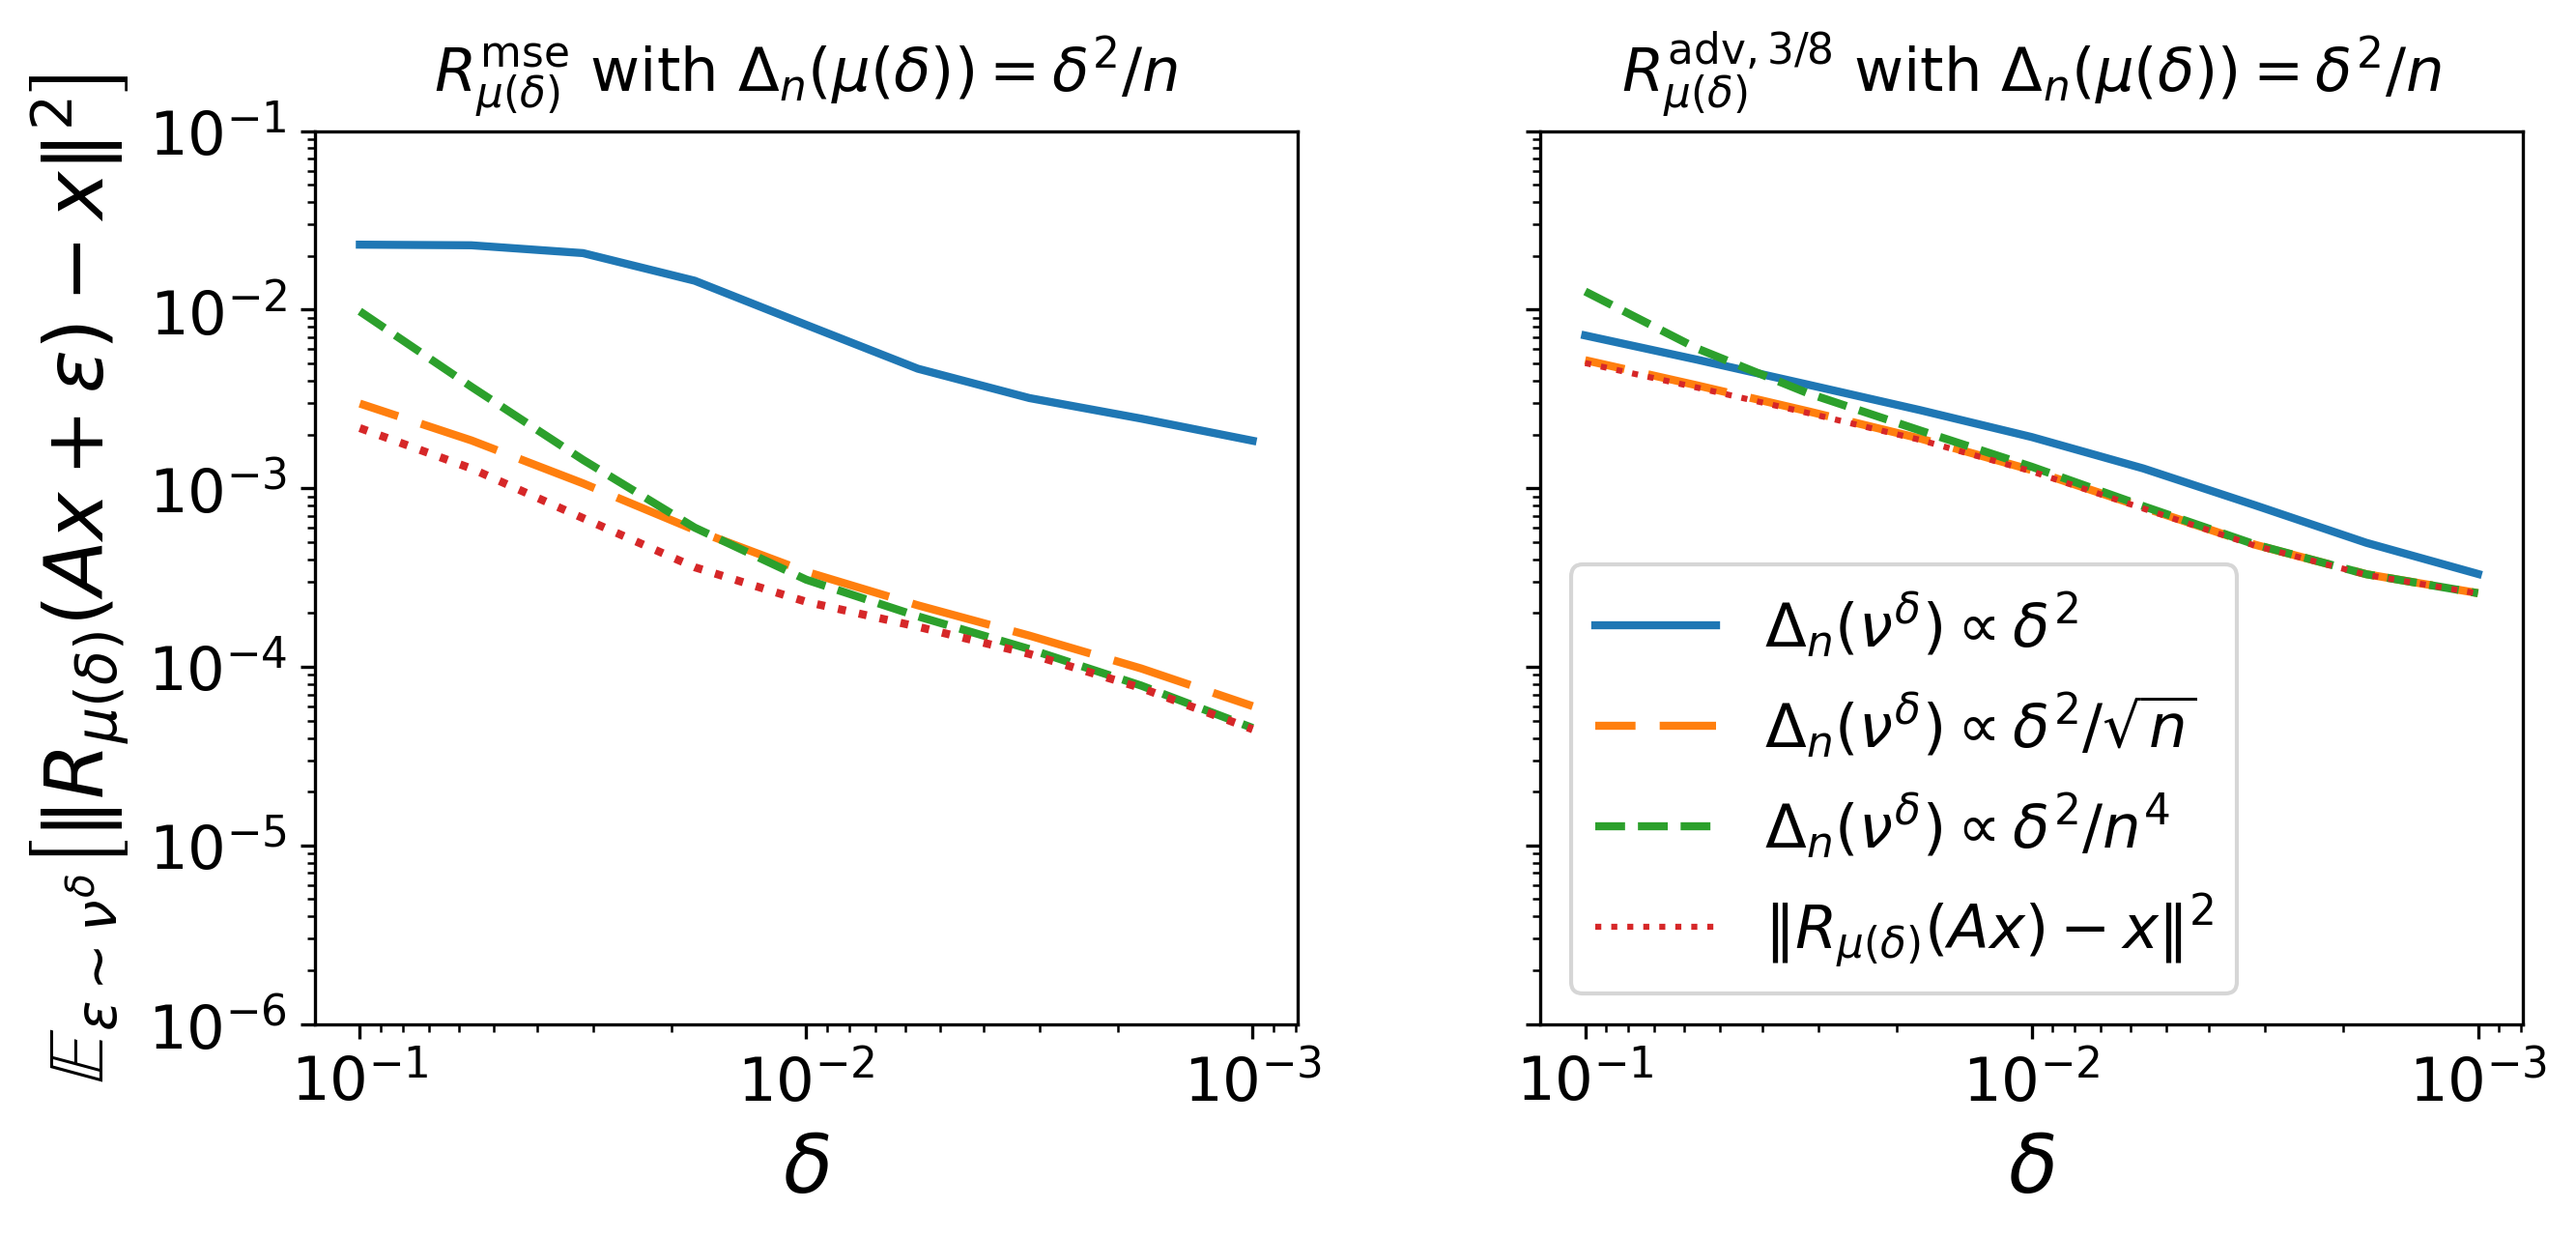

In [9]:
g,axs= plt.subplots(1,2, sharey=True, figsize=(10,4), dpi=300)
axs[0].loglog(deltas,  np.array(noise_error['mse']['less']) + np.array(data_error['mse']), ls= 'solid', linewidth=2, label=r'$\Delta_n(\nu^\delta) \propto \delta^2$')
axs[0].loglog(deltas,  np.array(noise_error['mse']['training']) + np.array(data_error['mse']), ls= (5, (10, 3)), linewidth=2, label= r'$\Delta_n(\nu^\delta) \propto \delta^2/\sqrt{n}$')
axs[0].loglog(deltas,  np.array(noise_error['mse']['more']) + np.array(data_error['mse']), ls= 'dashed', linewidth=2, label=r'$\Delta_n(\nu^\delta) \propto  \delta^2/n^4$')
axs[0].loglog(deltas, np.array(data_error['mse']), label = r'$\|R_{\mu(\delta)} (Ax) - x \|^2$', ls = 'dotted', linewidth = 2)

axs[0].set_ylim(1e-6, 1e-1)
axs[0].tick_params(axis='x', labelsize=15)
axs[0].tick_params(axis='y', labelsize=15)
axs[0].set_xlabel(r'$\delta$', fontsize=20)
axs[0].set_ylabel(r'$\mathbb{E}_{\epsilon \sim \nu^{\delta} }  \left[\| R_{\mu(\delta)} (Ax+\epsilon) - x \|^2 \right ]$', fontsize=20)
axs[0].set_title(r'$R^{\mathrm{mse}}_{\mu(\delta)}$ with $\Delta_n(\mu(\delta)) = \delta^2/n$', fontsize=15,  pad = 10)
axs[0].invert_xaxis()
axs[0].set_aspect(0.4)

axs[1].loglog(deltas,  np.array(noise_error['adv']['less']) + np.array(data_error['adv']), ls= 'solid', linewidth=2, label=r'$\Delta_n(\nu^\delta) \propto \delta^2$')
axs[1].loglog(deltas,  np.array(noise_error['adv']['training']) + np.array(data_error['adv']), ls=(5, (10, 3)), linewidth=2, label= r'$\Delta_n(\nu^\delta) \propto \delta^2/\sqrt{n}$')
axs[1].loglog(deltas,  np.array(noise_error['adv']['more']) + np.array(data_error['adv']), ls= 'dashed', linewidth=2, label=r'$\Delta_n(\nu^\delta) \propto \delta^2/n^4$')
axs[1].loglog(deltas, np.array(data_error['adv']), label = r'$\|R_{\mu(\delta)} (Ax) - x \|^2$', ls='dotted')

axs[1].tick_params(axis='x', labelsize=15)
axs[1].set_xlabel(r'$\delta$', fontsize=20)
axs[1].set_title(r'$R^{\mathrm{adv,}3/8}_{\mu(\delta)}$ with $\Delta_n(\mu(\delta)) = \delta^2/n$', fontsize=15, pad=10)
axs[1].invert_xaxis()
axs[1].set_aspect(0.4)
axs[1].legend(fontsize=15)

plt.show()

### 🔎 And now, let's have a look at the error curves for $R_\mu^{\mathrm{post}}$.
#### 💡The upper bound $\sum_{n \in N} \delta^2 / \sigma_n^2$ is only finite in finite dimensions or for very well-posed inverse problems.

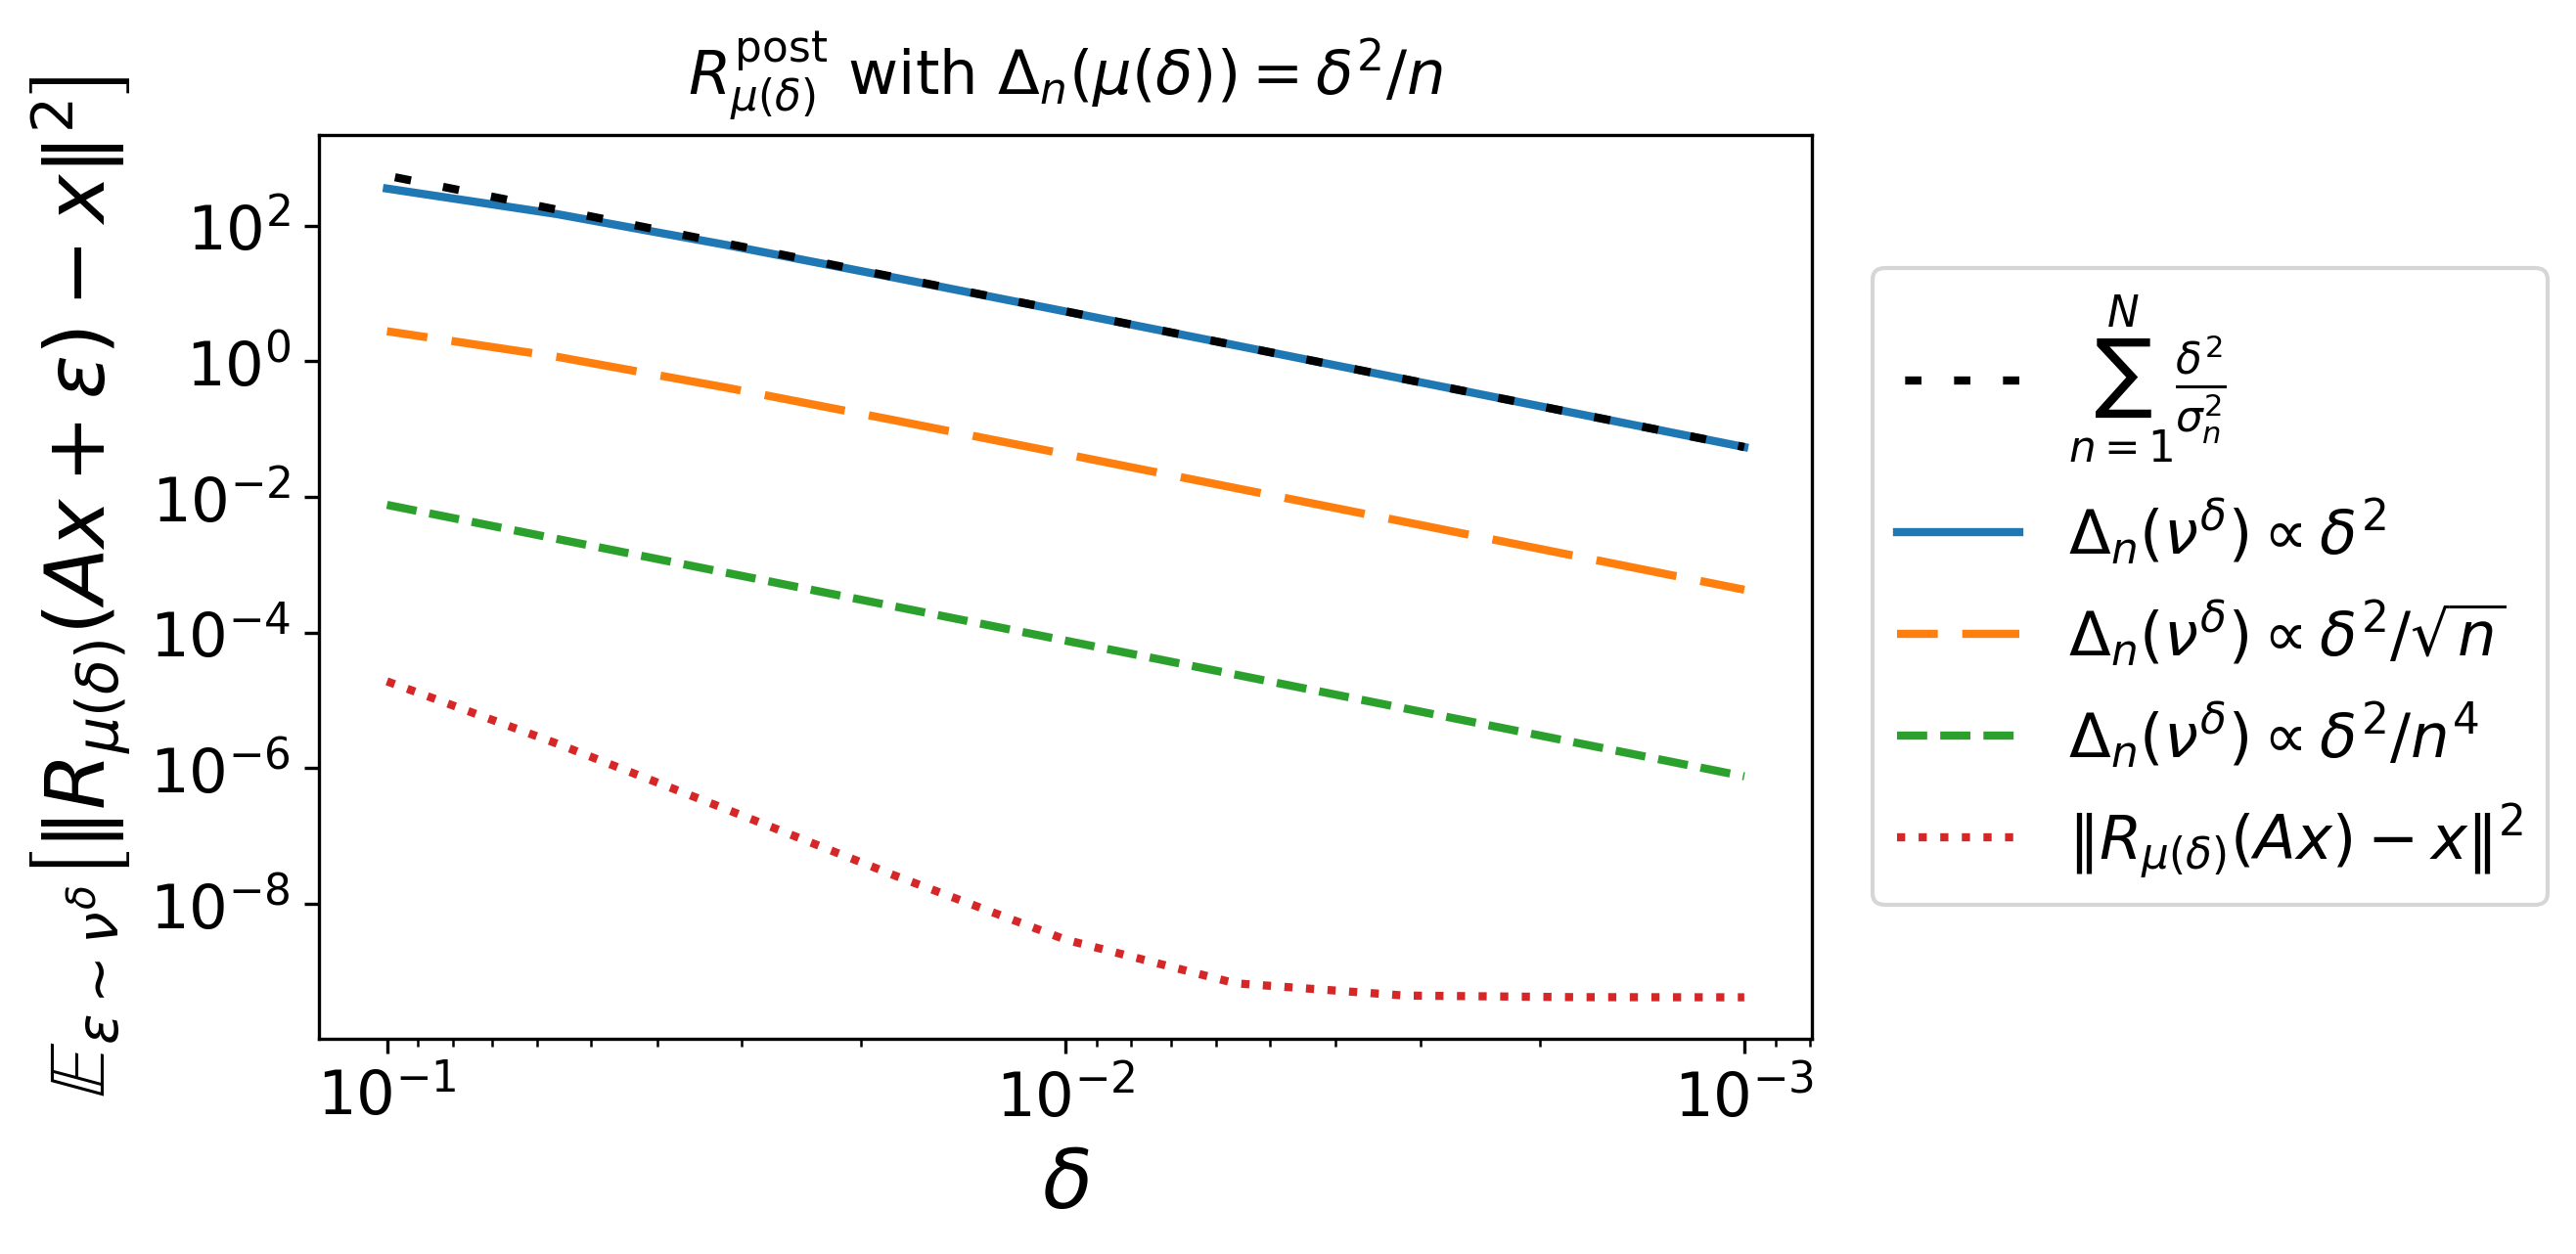

In [10]:
g,axs= plt.subplots(1,1, sharey=True, figsize=(10,4), dpi=300)
axs.loglog(deltas,  np.array(noise_error['post']['less']) + np.array(data_error['post']), ls= 'solid', linewidth=2, label=r'$\Delta_n(\nu^\delta) \propto \delta^2$')
axs.loglog(deltas,  np.array(noise_error['post']['training']) + np.array(data_error['post']), ls=(5, (10, 3)), linewidth=2, label= r'$\Delta_n(\nu^\delta) \propto \delta^2/\sqrt{n}$')
axs.loglog(deltas,  (np.array(noise_error['post']['more']) + np.array(data_error['post'])), ls= 'dashed', linewidth=2, label=r'$\Delta_n(\nu^\delta) \propto  \delta^2/n^4$')
axs.loglog(deltas, np.array(data_error['post']), label = r'$\|R_{\mu(\delta)} (Ax) - x \|^2$', ls='dotted', linewidth = 2)
axs.loglog(deltas,  np.array(deltas)**2*np.mean(1/r.sigma**2), linewidth=2, label=r'$ \sum_{n = 1}^N \frac{\delta^2}{\sigma_n^2}$', ls = (5, (2, 4)), color = 'black')

axs.tick_params(axis='x', labelsize=15)
axs.tick_params(axis='y', labelsize=15)
axs.set_xlabel(r'$\delta$', fontsize=20)
axs.set_ylabel(r'$\mathbb{E}_{\epsilon \sim \nu^{\delta} }  \left[\| R_{\mu(\delta)} (Ax+\epsilon) - x \|^2 \right ]$', fontsize=20)
axs.set_title(r'$R^{\mathrm{post}}_{\mu(\delta)}$ with $\Delta_n(\mu(\delta)) = \delta^2/n$', fontsize=15,  pad = 10)
axs.invert_xaxis()
axs.set_aspect(0.1)
handles, labels = plt.gca().get_legend_handles_labels()
order = [4,0,1,2,3]
axs.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=15,  bbox_to_anchor=(1.02, 0.5), loc="center left")

plt.show()